In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [21]:
def fetch_spy_data(start_date, end_date, interval='1d'):
    """
    Fetch SPY data using yfinance API
    """
    spy = yf.Ticker("SPY")
    df = spy.history(start=start_date, end=end_date, interval=interval)
    df = df.reset_index()
    return df

In [ ]:
def calculate_atr(data, window=14):
    """
    Calculate Average True Range (ATR) for dynamic grid spacing.
    """
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift(1))
    low_close = np.abs(data['Low'] - data['Close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(window=window).mean()
    return atr


In [ ]:
def generate_dynamic_grid_levels(price, atr, num_levels=10):
    """
    Generate dynamic grid levels using ATR as the spacing metric.
    """
    levels_above = [price + i * atr for i in range(1, num_levels + 1)]
    levels_below = [price - i * atr for i in range(1, num_levels + 1)]
    return sorted(levels_below + levels_above)


In [ ]:
def generate_grid_signals(data, num_levels=10, atr_window=14):
    """
    Generate buy/sell signals based on dynamic grid levels.
    """
    atr = calculate_atr(data, window=atr_window)
    signals = []
    for i, row in data.iterrows():
        price = row['Close']
        grid_levels = generate_dynamic_grid_levels(price, atr[i], num_levels)
        # Compare price with grid levels to determine signals
        signal = "HOLD"
        if price <= grid_levels[0]:  # Buy at lower grid
            signal = "BUY"
        elif price >= grid_levels[-1]:  # Sell at upper grid
            signal = "SELL"
        signals.append(signal)
    data['Signal'] = signals
    return data


In [ ]:
def calculate_position_size(portfolio_value, risk_per_trade, atr):
    """
    Calculate position size based on portfolio risk and ATR.
    """
    risk_dollars = portfolio_value * risk_per_trade
    position_size = risk_dollars / atr  # Volatility-adjusted size
    return int(position_size)  # Ensure it's a whole number of shares


In [24]:
def backtest_grid_strategy(data, initial_capital=100000, transaction_cost=0.001):
    """
    Backtest the grid trading strategy
    """
    portfolio = pd.DataFrame(index=data.index)
    portfolio['Price'] = data['Close']
    portfolio['Signal'] = data['Signal']
    portfolio['Grid_Level'] = data['Grid_Level']
    
    # Initialize portfolio metrics
    portfolio['Position'] = 0
    portfolio['Cash'] = initial_capital
    portfolio['Holdings'] = 0
    portfolio['Portfolio_Value'] = initial_capital
    
    position = 0
    cash = initial_capital
    
    for i in range(1, len(portfolio)):
        price = portfolio['Price'].iloc[i]
        signal = portfolio['Signal'].iloc[i]
        
        # Execute trades based on signals
        if signal == 1:  # Buy signal
            shares_to_buy = cash * 0.1 // price  # Use 10% of available cash
            if shares_to_buy > 0:
                cost = shares_to_buy * price * (1 + transaction_cost)
                if cost <= cash:
                    position += shares_to_buy
                    cash -= cost
                    
        elif signal == -1:  # Sell signal
            if position > 0:
                shares_to_sell = position * 0.1  # Sell 10% of position
                revenue = shares_to_sell * price * (1 - transaction_cost)
                position -= shares_to_sell
                cash += revenue
        
        # Update portfolio metrics
        portfolio.loc[portfolio.index[i], 'Position'] = position
        portfolio.loc[portfolio.index[i], 'Cash'] = cash
        portfolio.loc[portfolio.index[i], 'Holdings'] = position * price
        portfolio.loc[portfolio.index[i], 'Portfolio_Value'] = cash + (position * price)
    
    return portfolio

In [25]:
def plot_results(data, portfolio):
    """
    Plot trading results
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot 1: Price and Signals
    ax1.plot(data.index, data['Close'], label='SPY Price', alpha=0.5)
    
    # Plot buy signals
    buys = data[data['Signal'] == 1]
    ax1.scatter(buys.index, buys['Close'], 
               color='green', marker='^', s=100, label='Buy Signal')
    
    # Plot sell signals
    sells = data[data['Signal'] == -1]
    ax1.scatter(sells.index, sells['Close'], 
               color='red', marker='v', s=100, label='Sell Signal')
    
    ax1.set_title('SPY Price and Grid Trading Signals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Portfolio Value
    ax2.plot(portfolio.index, portfolio['Portfolio_Value'], 
             label='Portfolio Value', color='blue')
    ax2.set_title('Portfolio Value Over Time')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Value ($)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2836/2548991529.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9099.339558166505' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.loc[portfolio.index[i], 'Cash'] = cash
/tmp/ipykernel_2836/2548991529.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '899.7606811523438' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.loc[portfolio.index[i], 'Holdings'] = position * price
/tmp/ipykernel_2836/2548991529.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9999.100239318848' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.loc[portfolio.index[i], 'Portfolio_Value'] = cash +

Total Return: 24.64%
Total Trades: 825
Final Portfolio Value: $12,463.58


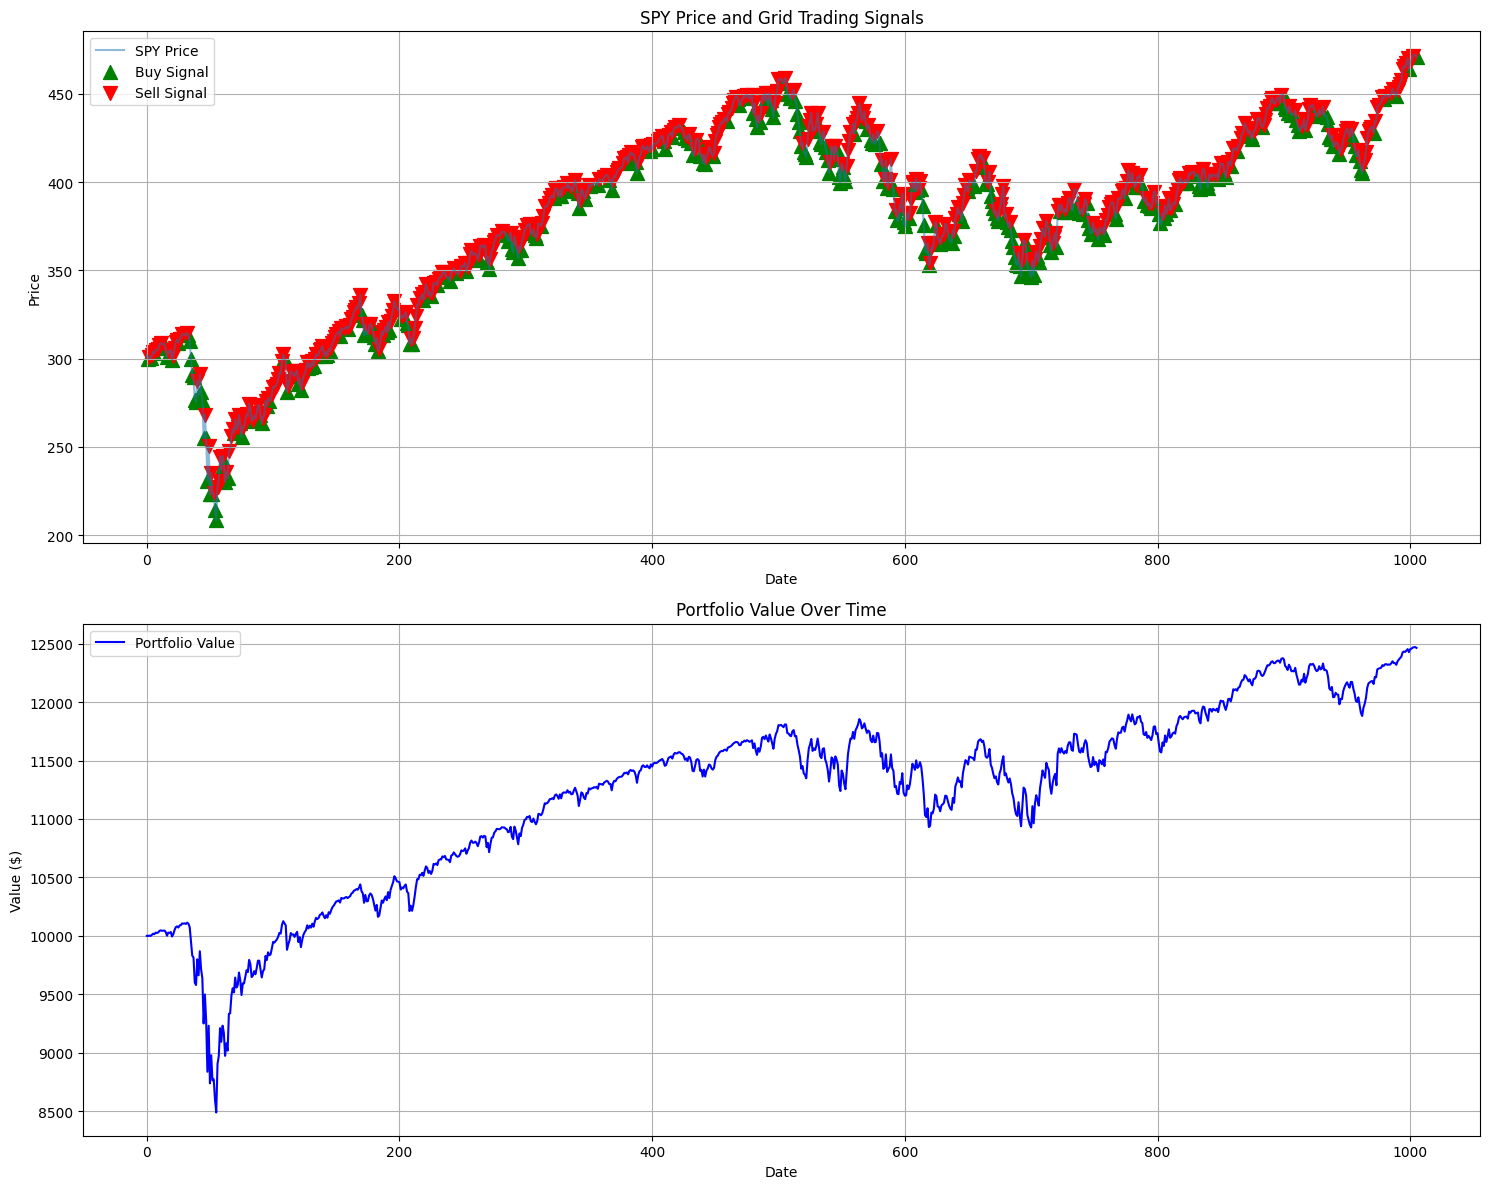

In [29]:
start_date = '2020-01-01'
end_date = '2023-12-31'
grid_spacing_pct = 0.2
initial_capital = 10000

# Fetch data
data = fetch_spy_data(start_date, end_date)

# Generate signals
data = generate_grid_signals(data, grid_spacing_pct)

# Run backtest
portfolio = backtest_grid_strategy(data, initial_capital)

# Calculate and display metrics
total_return = (portfolio['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital * 100
total_trades = len(data[data['Signal'] != 0])

print(f"Total Return: {total_return:.2f}%")
print(f"Total Trades: {total_trades}")
print(f"Final Portfolio Value: ${portfolio['Portfolio_Value'].iloc[-1]:,.2f}")

# Plot results
plot_results(data, portfolio)